In [1]:
#Imports
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import datetime as dt
import praw

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [2]:
#allows all columns to be scrolled
pd.set_option('display.max_columns', None)

# Source:https://stackoverflow.com/questions/47022070/display-all-dataframe-columns-in-a-jupyter-python-notebook/47022213 

In [3]:
#displays all text in dataframes
pd.set_option('display.max_colwidth', None)

# https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin

# Read In Our Data

In [4]:
alexa_google = pd.read_csv('./data/alexa_google_cleaned.csv')

# Modeling

## Train test split

In [5]:
X = alexa_google['text']
y = alexa_google['class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

## Baseline Score

In [7]:
y.value_counts(normalize=True)

1    0.509184
0    0.490816
Name: class, dtype: float64

### Our baseline is to predict correct more than 50% of the time

-----------

# Logistic Regression

### Pipeline

Going to add `CountVectorizer` with `stop_words='english'` to remove the common words from the dataset

In [8]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

In [9]:
pipe_params_lr = {
    'cvec__max_features' : [2000, 3000, 4000, 5000], 
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [.90,95],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

In [10]:
gs_lr = GridSearchCV(pipe_lr, # what object are we optimizing?
                  param_grid=pipe_params_lr, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [11]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [12]:
gs_lr.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2000, min_df=3,
                                 stop_words='english')),
                ('lr', LogisticRegression())])

In [13]:
print(f'Train accuracy: {gs_lr.score(X_train, y_train)}')
print(f'Test accuracy: {gs_lr.score(X_test, y_test)}')

Train accuracy: 0.9972789115646259
Test accuracy: 0.9326530612244898


In [14]:
gs_lr.best_score_

0.9312925170068027

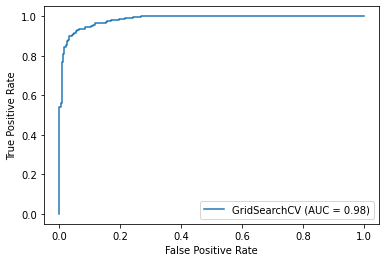

In [15]:
plot_roc_curve(gs_lr, X_test, y_test);
plt.savefig('./imgs/log_reg1_curve.jpeg',bbox_inches='tight');

In [16]:
preds_lr = gs_lr.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_lr).ravel()

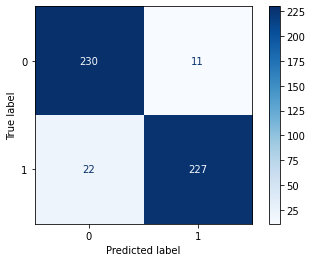

In [17]:
# View confusion matrix
plot_confusion_matrix(gs_lr, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig('./imgs/log_reg1_confusion.jpeg',bbox_inches='tight');

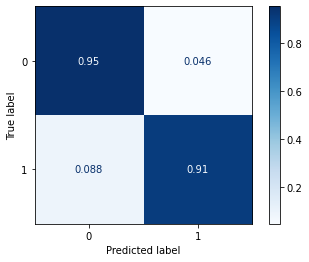

In [18]:
# View normalized confusion matrix
plot_confusion_matrix(gs_lr, X_test, y_test, cmap='Blues', normalize='true');
plt.savefig('./imgs/log_reg1_confusion_norm.jpeg',bbox_inches='tight');

# Random Forest

In [19]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier())
])

In [20]:
model_params = {}
count = 0

In [21]:
#Scaffolding

params_rf = {
    'rf__n_estimators' : [85,90,95], #number of trees
    'rf__max_features' : [None,1000], 
    'rf__max_depth' : [6,3,9]
    
}

gs_rf = GridSearchCV(pipe_rf, 
                 param_grid=params_rf,
                 cv=5)

gs_rf.fit(X_train, y_train)

#this takes the best params dictionary and adds a column called score
gs_rf.best_params_['score'] = gs_rf.best_score_

#make a counter
count +=1

#create new column with best params
model_params[f'model_{count}'] = gs_rf.best_params_

#orient sideways
model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

#Code oriented from General Assembly DSI Lesson 6.03 Random Forests

,rf__max_depth,rf__max_features,rf__n_estimators,score
model_1,9,1000,95,0.934694


In [22]:
print(f'Train accuracy: {gs_rf.score(X_train, y_train)}')
print(f'Test accuracy: {gs_rf.score(X_test, y_test)}')

Train accuracy: 0.9653061224489796
Test accuracy: 0.9142857142857143


In [23]:
gs_rf.best_params_

{'rf__max_depth': 9,
 'rf__max_features': 1000,
 'rf__n_estimators': 95,
 'score': 0.9346938775510203}

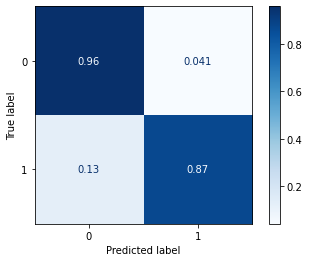

In [24]:
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues', normalize='true');
plt.savefig('./imgs/rand_forest_confusion_norm.jpeg',bbox_inches='tight');

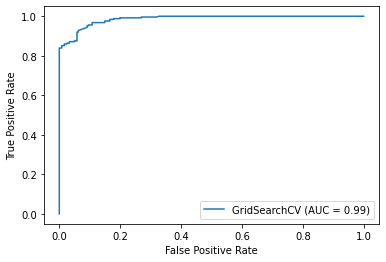

In [25]:
plot_roc_curve(gs_rf, X_test, y_test);
plt.savefig('./imgs/rf1_curve.jpeg',bbox_inches='tight');

## Our models are both performing above 90% accuracy, let's investigate why?

---------

# Most Frequent Words

In [26]:
def most_freq(subreddit):
    
    #instantiate CountVectorizer
    cvec_df = CountVectorizer(stop_words='english')
    
    #select subreddit and fit
    X_series = alexa_google[alexa_google['subreddit'] == subreddit]['text']
    X_series =  cvec_df.fit_transform(X_series)
    
    #convert to a dataframe
    X_df = pd.DataFrame(X_series.toarray(),
    columns=cvec_df.get_feature_names())
    
    # create empty dictionary
    top_words = {}

    # loop through columns
    for i in X_df.columns:
        # save sum of each column in dictionary
        top_words[i] =  X_df[i].sum()

    # top_words to dataframe sorted by highest occurance
    most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))
    
    return most_freq

### GoogleHome

In [27]:
google_most_freq =  most_freq('googlehome')

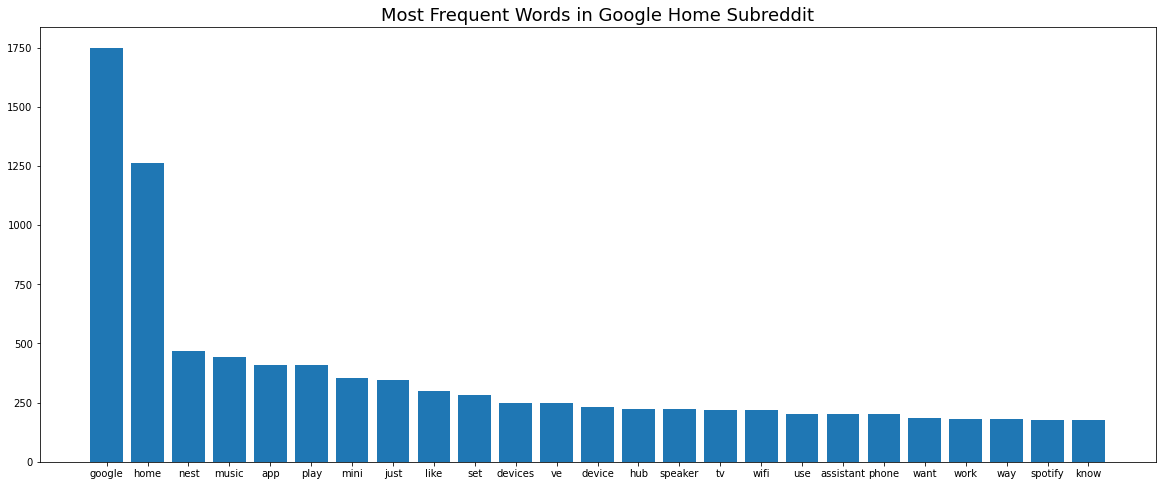

In [28]:
plt.figure(figsize=(20,8))
plt.bar(google_most_freq[0][:25], google_most_freq[1][:25])
plt.title('Most Frequent Words in Google Home Subreddit',fontsize=18);
plt.savefig('./imgs/google_most_freq_1.jpeg',bbox_inches='tight');

### Alexa

In [29]:
alexa_most_freq = most_freq('alexa')

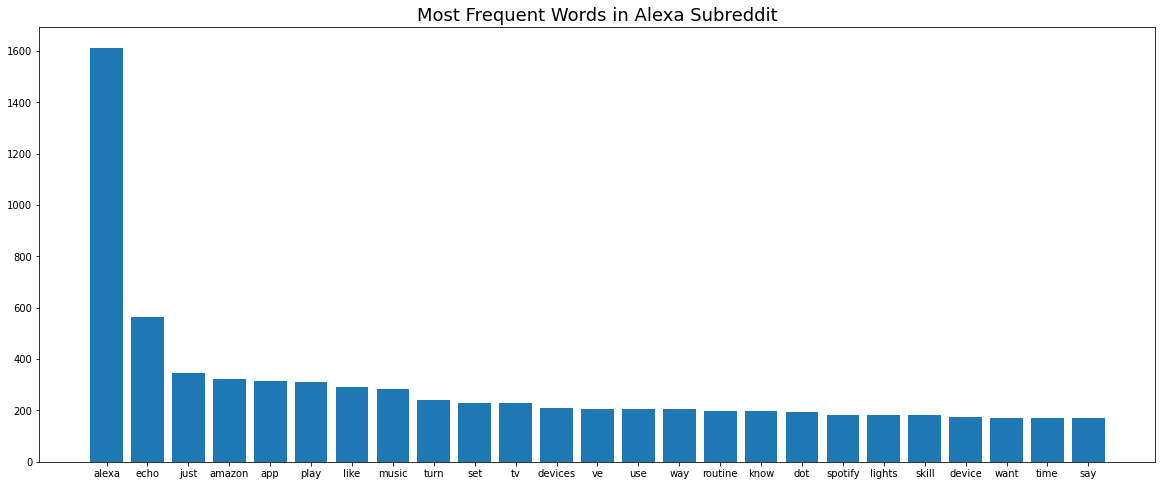

In [30]:
plt.figure(figsize=(20,8))
plt.bar(alexa_most_freq[0][:25], alexa_most_freq[1][:25])
plt.title('Most Frequent Words in Alexa Subreddit',fontsize=18);
plt.savefig('./imgs/alexa_most_freq_1.jpeg',bbox_inches='tight');

## Conclusion: Since the words `alexa` and `google` show up so frequently in the posts, let's see if we can make it more challenging to predict the class by removing some of the most popular words.

#### Let's find which words are not in both datasets and choose which ones we want to take out.

In [31]:
# create two lists
alexa_top_25 = [word for word in alexa_most_freq[0][:25]]
google_top_25 = [word for word in google_most_freq[0][:25]]

In [32]:
#unique to each dataset
words_to_remove = [i for i in alexa_top_25 + google_top_25 if i not in alexa_top_25 or i not in google_top_25]
words_to_remove

#code adapted from https://www.geeksforgeeks.org/python-difference-two-lists/

['alexa',
 'echo',
 'amazon',
 'turn',
 'routine',
 'dot',
 'lights',
 'skill',
 'time',
 'say',
 'google',
 'home',
 'nest',
 'mini',
 'hub',
 'speaker',
 'wifi',
 'assistant',
 'phone',
 'work']

In [33]:
#same in each dataset
same_words = set(alexa_top_25) & set(google_top_25)
same_words

{'app',
 'device',
 'devices',
 'just',
 'know',
 'like',
 'music',
 'play',
 'set',
 'spotify',
 'tv',
 'use',
 've',
 'want',
 'way'}